## Fake News Detection on Twitter
## This notebook implements a Fake News Detection System to classify tweets as Real or Fake using NLP and Machine Learning.

## 1. Load and Explore Data

In [4]:

# Load the datasets and inspect their structure.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Load datasets
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')
submission_df = pd.read_csv('/content/sample_submission.csv')

# Display dataset info
print('Train Data:')
display(train_df.head())
print(train_df.info())

print('Test Data:')
display(test_df.head())
print(test_df.info())

Train Data:


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
Test Data:


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


## 2. Data Cleaning

Missing values after cleaning:
id                0
keyword           0
location          0
text              0
target            0
processed_text    0
dtype: int64
id                0
keyword           0
location          0
text              0
processed_text    0
dtype: int64


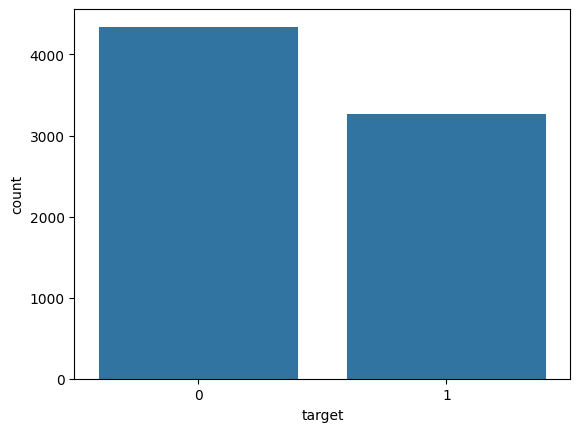

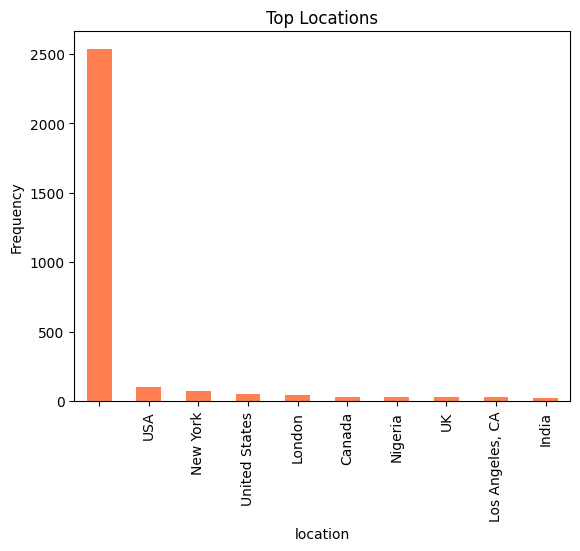

In [21]:

# Handle missing values
train_df['keyword'] = train_df['keyword'].fillna('')
train_df['location'] = train_df['location'].fillna('')
test_df['keyword'] = test_df['keyword'].fillna('')
test_df['location'] = test_df['location'].fillna('')

# Inspect cleaned data
print('Missing values after cleaning:')
print(train_df.isnull().sum())
print(test_df.isnull().sum())

sns.countplot(x='target',data=train_df)
plt.show()
# To show locations
top_locations = train_df['location'].value_counts().head(10)
top_locations.plot(kind='bar', color='coral')
plt.title('Top Locations')
plt.ylabel('Frequency')

plt.show()

##More Exploration


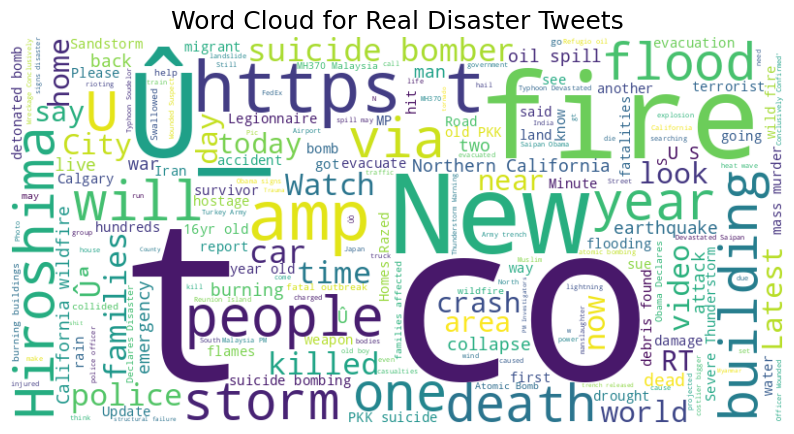

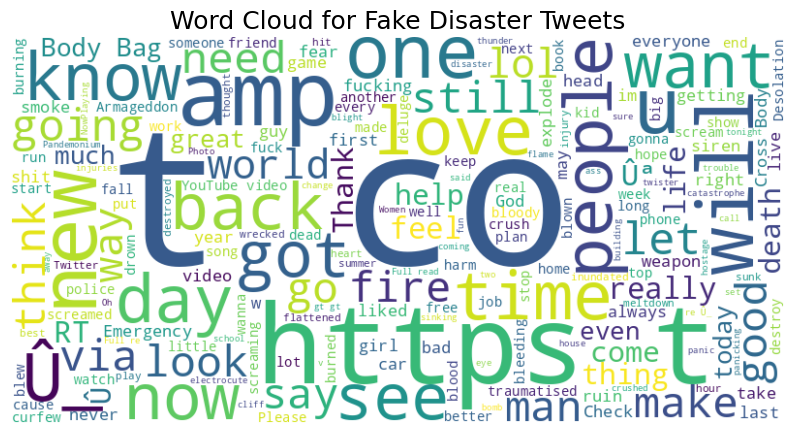

In [8]:
import re
from wordcloud import WordCloud
def plot_wordcloud(data, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=18)
    plt.show()

plot_wordcloud(train_df[train_df['target'] == 1]['text'], 'Word Cloud for Real Disaster Tweets')
plot_wordcloud(train_df[train_df['target'] == 0]['text'], 'Word Cloud for Fake Disaster Tweets')

## 3. Text Preprocessing

In [9]:
import nltk
nltk.download('stopwords')

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Example preprocessing function
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

# Apply preprocessing
train_df['processed_text'] = train_df['text'].apply(preprocess_text)
test_df['processed_text'] = test_df['text'].apply(preprocess_text)

# Display processed data
train_df[['text', 'processed_text']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,processed_text
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquak may allah forgiv us
1,Forest fire near La Ronge Sask. Canada,forest fire near la rong sask canada
2,All residents asked to 'shelter in place' are ...,resid ask shelter place notifi offic evacu she...
3,"13,000 people receive #wildfires evacuation or...",peopl receiv wildfir evacu order california
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo rubi alaska smoke wildfir pour ...


## 4. Feature Extraction


In [10]:
# Transform text data into numerical features using CountVectorizer and TF-IDF.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Feature extraction using TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train = tfidf.fit_transform(train_df['processed_text']).toarray()
X_test = tfidf.transform(test_df['processed_text']).toarray()
y_train = train_df['target']

print('TF-IDF Features:')
print(X_train.shape, X_test.shape)


TF-IDF Features:
(7613, 5000) (3263, 5000)


## 5. Model Training and Evaluation

In [11]:
# Train machine learning models and evaluate their performance.

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Split data
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train_split, y_train_split)
log_reg_pred = log_reg.predict(X_val)
print('Logistic Regression Report:')
print(classification_report(y_val, log_reg_pred))


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       874
           1       0.80      0.68      0.74       649

    accuracy                           0.79      1523
   macro avg       0.80      0.78      0.78      1523
weighted avg       0.80      0.79      0.79      1523



In [ ]:
# Train Support Vector Machine
svm = SVC(probability=True)
svm.fit(X_train_split, y_train_split)
svm_pred = svm.predict(X_val)
print('Support Vector Machine Report:')
print(classification_report(y_val, svm_pred))

In [12]:
# Train Naive Bayes Classifier
nb = MultinomialNB()
nb.fit(X_train_split, y_train_split)
nb_pred = nb.predict(X_val)
print('Naive Bayes Report:')
print(classification_report(y_val, nb_pred))

Naive Bayes Report:
              precision    recall  f1-score   support

           0       0.79      0.88      0.84       874
           1       0.81      0.69      0.75       649

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



In [ ]:
# Compare performance
print('Model Comparison:')
print(f'Logistic Regression Accuracy: {accuracy_score(y_val, log_reg_pred)}')
print(f'SVM Accuracy: {accuracy_score(y_val, svm_pred)}')
print(f'Naive Bayes Accuracy: {accuracy_score(y_val, nb_pred)}')

## 6. Hyperparameter Tuning

In [13]:
# Optimize model performance using GridSearchCV or RandomizedSearchCV.

from sklearn.model_selection import GridSearchCV

# Example hyperparameter tuning for Logistic Regression
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_log_reg = GridSearchCV(LogisticRegression(), param_grid, scoring='accuracy', cv=5)
grid_log_reg.fit(X_train_split, y_train_split)

print('Best Parameters for Logistic Regression:', grid_log_reg.best_params_)
print('Best Score for Logistic Regression:', grid_log_reg.best_score_)



Best Parameters for Logistic Regression: {'C': 1}
Best Score for Logistic Regression: 0.7952380952380953


In [ ]:
# Hyperparameter tuning for SVM
param_grid_svm = {'C': [0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid_svm = GridSearchCV(SVC(probability=True), param_grid_svm, scoring='accuracy', cv=5,n_jobs=-1)
grid_svm.fit(X_train_split, y_train_split)

print('Best Parameters for SVM:', grid_svm.best_params_)
print('Best Score for SVM:', grid_svm.best_score_)

In [14]:
# Hyperparameter tuning for Naive Bayes
param_grid_nb = {'alpha': [0.01, 0.1, 0.5, 1.0, 5.0]}
grid_nb = GridSearchCV(MultinomialNB(), param_grid_nb, scoring='accuracy', cv=5)
grid_nb.fit(X_train_split, y_train_split)

print('Best Parameters for Naive Bayes:', grid_nb.best_params_)
print('Best Score for Naive Bayes:', grid_nb.best_score_)

Best Parameters for Naive Bayes: {'alpha': 1.0}
Best Score for Naive Bayes: 0.8008210180623975


## 7. Visualization and Analysis

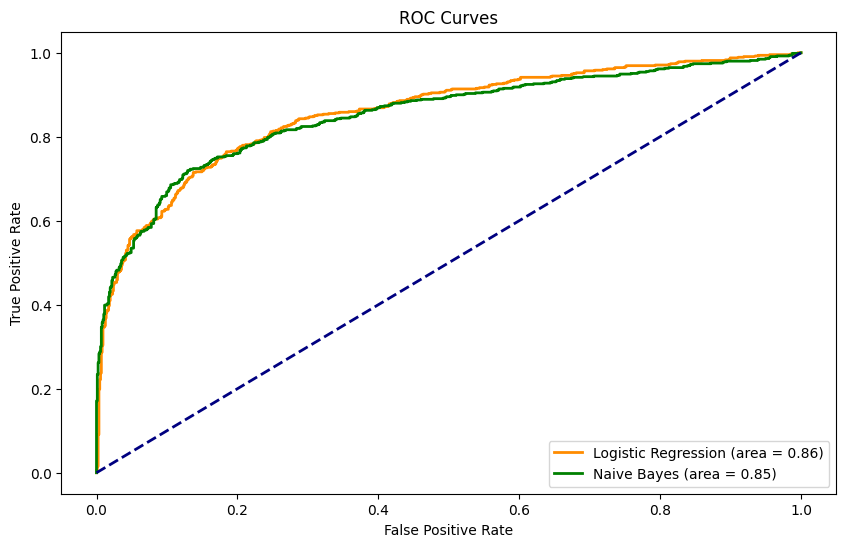

Misclassified examples:
Example 1: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all | Predicted: 0, Actual: 1
Example 2: #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas | Predicted: 0, Actual: 1
Example 3: I'm on top of the hill and I can see a fire in the woods... | Predicted: 0, Actual: 1
Example 4: I love fruits | Predicted: 1, Actual: 0
Example 5: London is cool ;) | Predicted: 1, Actual: 0


In [15]:
# Analyze model performance and visualize results.

# Plot ROC Curve
from sklearn.metrics import roc_curve, auc

# Logistic Regression ROC
fpr_log, tpr_log, _ = roc_curve(y_val, grid_log_reg.best_estimator_.predict_proba(X_val)[:, 1])
roc_auc_log = auc(fpr_log, tpr_log)

# Naive Bayes ROC
fpr_nb, tpr_nb, _ = roc_curve(y_val, grid_nb.best_estimator_.predict_proba(X_val)[:, 1])
roc_auc_nb = auc(fpr_nb, tpr_nb)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(fpr_log, tpr_log, color='darkorange', lw=2, label='Logistic Regression (area = %0.2f)' % roc_auc_log)
plt.plot(fpr_nb, tpr_nb, color='green', lw=2, label='Naive Bayes (area = %0.2f)' % roc_auc_nb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

# Display misclassified examples
misclassified = X_val[y_val != log_reg_pred]
misclassified_indices = np.where(y_val != log_reg_pred)[0]
print("Misclassified examples:")
for i, index in enumerate(misclassified_indices[:5]):
    print(f"Example {i+1}: {train_df['text'].iloc[index]} | Predicted: {log_reg_pred[index]}, Actual: {y_val.iloc[index]}")


## 8. Final Submission

In [19]:
# Generate predictions on the test set and prepare the submission file.

# Choose the best performing model from the previous steps - here, assuming grid_nb is the best
model = grid_nb.best_estimator_
print("Best Model used for submission:", model)
# Generate predictions
test_predictions = model.predict(X_test)

# Create submission file
submission_df['target'] = test_predictions
submission_df.to_csv('submission.csv', index=False)

Best Model used for submission: MultinomialNB()
